# Content Based Recommendation using the Descriptions

## Imports

In [ ]:
!pip install transformers
!pip3 install pickle5

In [ ]:
from google.colab import drive
import pickle5 as pickle
from transformers import BertModel, BertTokenizerFast, DistilBertModel, DistilBertTokenizerFast, \
XLMRobertaModel, XLMRobertaTokenizerFast, Trainer, TrainingArguments
import torch
import multiprocessing as mp
import numpy as np
import pandas as pd
import datetime
import gc
from os import listdir
from os.path import join
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def save_as_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [ ]:
drive.mount('/content/drive', force_remount=True)  # use force_remount=True param after upload of new data

# file and folder names
project_drive_folder = "Master/2 - FSS 2021/Data Mining II/Data Mining Cup" 
full_project_drive_folder = "/content/drive/My Drive/{}/Data/".format(project_drive_folder)

# general
items_path = full_project_drive_folder + 'DMC-2021-Task/items.csv'
evaluation_path = full_project_drive_folder + 'DMC-2021-Task/evaluation.csv'
google_crawl_path = full_project_drive_folder + 'CrawledData/GoogleBooksAPI/DM2_CompleteExport_withImages.csv'
# google_crawl_path = '/content/drive/My Drive/Master/2 - FSS 2021/Information Retrieval/IR Projekt/saved_models/neural_retrieval/GBooks_JSON_to_CSV.csv'

# summaries
encodings_path = full_project_drive_folder + 'descriptions/xlm_encodings.pkl'
embeddings_folder = full_project_drive_folder + 'descriptions/embeddings/'
embeddings_path = full_project_drive_folder + 'descriptions/xlm_embeddings.pkl'

# Amazon Data
amazon_test_path = full_project_drive_folder + 'Amazon/dmc21_amazon_test.csv'
amazon_val_path = full_project_drive_folder + 'Amazon/dmc21_amazon_validation.csv'
internal_amazon_path = full_project_drive_folder + 'Amazon/dictionnary_validation_data.pkl'

Mounted at /content/drive


## items.csv and Google Data

### Load & Merge

In [ ]:
items = pd.read_csv(items_path, sep='|')
google_data = pd.read_csv(google_crawl_path, sep='\t')
evaluation_items = pd.read_csv(evaluation_path)

In [ ]:
items.info()
google_data.info()
evaluation_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78030 entries, 0 to 78029
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   itemID      78030 non-null  int64 
 1   title       78030 non-null  object
 2   author      74790 non-null  object
 3   publisher   78021 non-null  object
 4   main topic  77772 non-null  object
 5   subtopics   78029 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78334 entries, 0 to 78333
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          78334 non-null  int64 
 1   title           78334 non-null  object
 2   author          75087 non-null  object
 3   publisher       78325 non-null  object
 4   main topic      78075 non-null  object
 5   subtopics       78334 non-null  object
 6   title_gbooks    72217 non-null  object
 7   authors_gboo

In [ ]:
items_enriched = items.merge(google_data, on='itemID', suffixes=['_i', '_g'])
items_enriched = items_enriched[items_enriched['description'] != 'NOT_FOUND']
items_enriched.dropna(subset=['description'], inplace=True)
items_enriched.info()
# items_enriched.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62345 entries, 0 to 78029
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          62345 non-null  int64 
 1   title_i         62345 non-null  object
 2   author_i        61256 non-null  object
 3   publisher_i     62343 non-null  object
 4   main topic_i    62203 non-null  object
 5   subtopics_i     62344 non-null  object
 6   title_g         62345 non-null  object
 7   author_g        61256 non-null  object
 8   publisher_g     62343 non-null  object
 9   main topic_g    62203 non-null  object
 10  subtopics_g     62345 non-null  object
 11  title_gbooks    62345 non-null  object
 12  authors_gbooks  62345 non-null  object
 13  language        62345 non-null  object
 14  description     62345 non-null  object
 15  previewLink     62345 non-null  object
 16  smallThumbnail  62345 non-null  object
 17  bigThumbnail    62345 non-null  object
dtypes: int

In [ ]:
item_indexes = items_enriched.copy()
item_indexes.reset_index(inplace=True)
item_indexes['item_index'] = item_indexes.index
item_indexes.drop(item_indexes.columns.difference(['item_index','itemID']), axis=1, inplace=True)

items_enriched = items_enriched.merge(item_indexes, on='itemID')

In [ ]:
evaluation_items_enriched = evaluation_items.merge(items).merge(google_data, on='itemID', suffixes=['_i', '_g'])
evaluation_items_enriched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   itemID          998 non-null    int64 
 1   title_i         998 non-null    object
 2   author_i        937 non-null    object
 3   publisher_i     997 non-null    object
 4   main topic_i    994 non-null    object
 5   subtopics_i     998 non-null    object
 6   title_g         998 non-null    object
 7   author_g        937 non-null    object
 8   publisher_g     997 non-null    object
 9   main topic_g    994 non-null    object
 10  subtopics_g     998 non-null    object
 11  title_gbooks    923 non-null    object
 12  authors_gbooks  923 non-null    object
 13  language        923 non-null    object
 14  description     923 non-null    object
 15  previewLink     923 non-null    object
 16  smallThumbnail  923 non-null    object
 17  bigThumbnail    923 non-null    object
dtypes: int64(1

### Statistics

             itemID    item_index  description_length
count  62345.000000  62345.000000        62345.000000
mean   39599.338664  31172.000000          713.821156
std    22812.030486  17997.595603          646.613250
min        0.000000      0.000000            3.000000
25%    19859.000000  15586.000000          343.000000
50%    39589.000000  31172.000000          632.000000
75%    59351.000000  46758.000000          957.000000
max    79067.000000  62344.000000       102723.000000
(38183, 20)


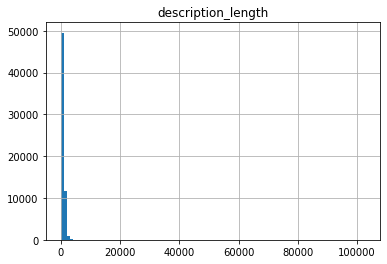

In [ ]:
items_enriched['description_length'] = items_enriched.apply(lambda row: len(row['description']), axis=1)
print(items_enriched.describe())
items_enriched.hist(column=['description_length'], bins=100)
print(items_enriched[items_enriched['description_length'] > 512].shape)

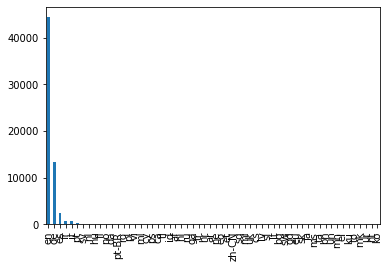

In [ ]:
items_enriched['language'].value_counts().plot(kind='bar')

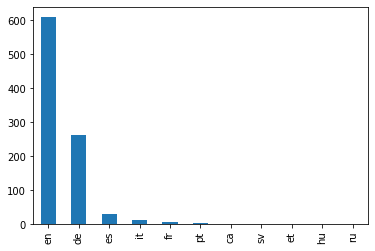

In [ ]:
evaluation_items_enriched['language'].value_counts().plot(kind='bar')

FM       5783
YFB      4118
FL       4047
YFA      3883
YFH      3499
         ... 
UDBS        1
YPCK9       1
XAB         1
YBLM        1
JBCT1       1
Name: main topic, Length: 493, dtype: int64


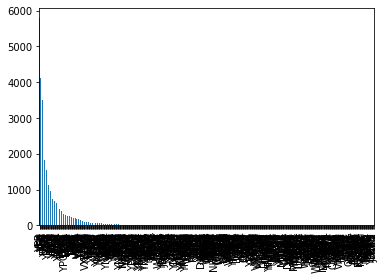

In [ ]:
print(items_enriched['main topic'].value_counts())
items_enriched['main topic'].value_counts().plot(kind='bar')

## Compute Embeddings

### Encode

In [ ]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')

In [ ]:
encodings = tokenizer.batch_encode_plus(list(items_enriched['description'].values), 
                                        truncation=True, padding="max_length", return_tensors="pt")
save_as_pickle(encodings, encodings_path)

In [ ]:
encodings = load_pickle(encodings_path)

In [ ]:
print(encodings['input_ids'].size())

torch.Size([62345, 512])


### Apply Model

In [ ]:
# model = BertModel.from_pretrained('bert-base-uncased')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, boundaries=None):
    if boundaries is not None:
      self.encodings = {key: val[boundaries[0]: boundaries[1]] for key, val in encodings.items()}
    else:
      self.encodings = encodings

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return item

  def __len__(self):
      return len(self.encodings['input_ids'])

# dataset = Dataset(encodings, (0, 1000))
# dataset = Dataset(encodings)
# print(len(dataset))
# dataset.__getitem__(10)

In [ ]:
trainer = Trainer(
    model = model
)

In [ ]:
def get_embeddings(dataset):
  prediction_output = trainer.predict(dataset)
  results = prediction_output.predictions[1]
  del prediction_output
  torch.cuda.empty_cache()
  gc.collect()
  return results

In [ ]:
subset_size = 1000

In [ ]:
for i in range(1000, len(encodings['input_ids']), subset_size):
  print(i)
  sub_dataset = Dataset(encodings, (i-subset_size, i))
  embedding_array = get_embeddings(sub_dataset)
  path = full_project_drive_folder + f'descriptions/embeddings/{i-subset_size}-{i}.pkl'
  save_as_pickle(embedding_array, path)
  print('saved', path)
  del sub_dataset
  del embedding_array
  torch.cuda.empty_cache()
  gc.collect()

In [ ]:
# rests
lower = 62000
upper = len(encodings['input_ids'])
sub_dataset = Dataset(encodings, (lower, upper))
embedding_array = get_embeddings(sub_dataset)
path = full_project_drive_folder + f'descriptions/embeddings/{lower}-{upper}.pkl'
save_as_pickle(embedding_array, path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
print(embedding_array.shape)

(345, 768)


### Combine Results

In [ ]:
embedding_arrays = [load_pickle(join(embeddings_folder, f)) for f in listdir(embeddings_folder) 
                                                              if load_pickle(join(embeddings_folder, f)).shape[1] == 768]
embeddings = np.concatenate(embedding_arrays)
save_as_pickle(embeddings, embeddings_path)

In [ ]:
embeddings = load_pickle(embeddings_path)

In [ ]:
embeddings.shape

(62345, 768)

## Recommend Amazon Data

### Load Data

In [ ]:
# amazon_test = pd.read_csv(amazon_test_path)
# amazon_val = pd.read_csv(amazon_val_path)
# amazon_val = amazon_val.merge(item_indexes, on='itemID', how='left')
# items_enriched_index is null if item is not in enriched data set (which contains descriptions)
# amazon_val.info()

In [ ]:
internal_amazon = load_pickle(internal_amazon_path)

In [ ]:
amazon_item_ids_df = pd.DataFrame.from_dict({'itemID': list(internal_amazon.keys())})
amazon_item_ids_df = amazon_item_ids_df.merge(item_indexes, how='left')
amazon_item_embedding_indexes = {int(row['itemID']): int(row['item_index']) if not np.isnan(row['item_index']) else None
                                  for idx, row in amazon_item_ids_df.iterrows()}
len(amazon_item_indexes)

232

### Enrich Internal File with Recommendations

In [ ]:
scaler = MinMaxScaler()

In [ ]:
for idx, (item_id, sim_df) in enumerate(internal_amazon.items()):

  print(f'{datetime.datetime.now()} {idx+1}/{len(internal_amazon)}')
  embedding_index = amazon_item_indexes[item_id]
  
  # if embedding_index is none there is no description and therefore no embedding -> skip this and set np.nan
  if embedding_index:
    # compute cosine values and normalize
    cosine_similarity_matrix = cosine_similarity(embeddings[embedding_index,:].reshape(1, -1), embeddings)
    similarities = scaler.fit_transform([[sim] for sim in cosine_similarity_matrix[0]])
    similarities = [sim[0] for sim in similarities]

    # merge bert similarity values with existing similarities from other methods
    item_ids = [items_enriched.iloc[idx]['itemID'] for idx, sim in enumerate(cosine_similarity_matrix[0])]
    bert_df = pd.DataFrame.from_dict({'bert': similarities, 'itemID': item_ids})
    sim_df_merged_bert = sim_df.merge(bert_df, on='itemID', how='left')

  # set then to np.nan
  else:
    sim_df_merged_bert['bert'] = np.nan
  
  internal_amazon[item_id] = sim_df_merged_bert

2021-06-01 20:07:28.375248 1/232
2021-06-01 20:07:35.967140 2/232
2021-06-01 20:07:43.395719 3/232
2021-06-01 20:07:50.909041 4/232
2021-06-01 20:07:58.330706 5/232
2021-06-01 20:08:05.831999 6/232
2021-06-01 20:08:13.355881 7/232
2021-06-01 20:08:20.782870 8/232
2021-06-01 20:08:20.784074 9/232
2021-06-01 20:08:28.321214 10/232
2021-06-01 20:08:35.825238 11/232
2021-06-01 20:08:35.826506 12/232
2021-06-01 20:08:43.427507 13/232
2021-06-01 20:08:43.428729 14/232
2021-06-01 20:08:50.805493 15/232
2021-06-01 20:08:58.314785 16/232
2021-06-01 20:08:58.315998 17/232
2021-06-01 20:09:05.863811 18/232
2021-06-01 20:09:13.288003 19/232
2021-06-01 20:09:20.791095 20/232
2021-06-01 20:09:28.233608 21/232
2021-06-01 20:09:35.649339 22/232
2021-06-01 20:09:43.213603 23/232
2021-06-01 20:09:50.641663 24/232
2021-06-01 20:09:50.642838 25/232
2021-06-01 20:09:58.220091 26/232
2021-06-01 20:10:05.819812 27/232
2021-06-01 20:10:13.322350 28/232
2021-06-01 20:10:20.779845 29/232
2021-06-01 20:10:28.169

In [ ]:
save_as_pickle(internal_amazon, internal_amazon_path)